# **Big Data Engineering, Final Project: Pneumonia identification from x-ray images**
## **Izana Alcalde Cercadillo, María Herranz Gilarranz, Jesús Mansilla Guardiola**
## MUBC 2025/2026
## Universidad Politécnica de Madrid




The objective of this assignment is to develop a model capable of detecting whether a patient suffers from pneumonia or is healthy through the Big Data Engineering methods learnt in class. The dataset used for the models is imported from Kaggle.

**The following code is designed to be executed within a Google Colab environment**

##**1. Data import and sort**

As a first step, the data is imported from Kaggle, to then be organized for easier use. The dataset is an assortment of torax x-ray images, sorted into different categories depending on whether the patient has pneumonia or not.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


Once the data is imported, we organize the variables for easy access to the different directories in the downloaded dataset.

In [ ]:
DATA_ROOT = "/kaggle/input/chest-xray-pneumonia/chest_xray"

TRAIN_NORMAL = f"{DATA_ROOT}/train/NORMAL"
TRAIN_PNEU   = f"{DATA_ROOT}/train/PNEUMONIA"

VAL_NORMAL   = f"{DATA_ROOT}/val/NORMAL"
VAL_PNEU     = f"{DATA_ROOT}/val/PNEUMONIA"

TEST_NORMAL  = f"{DATA_ROOT}/test/NORMAL"
TEST_PNEU    = f"{DATA_ROOT}/test/PNEUMONIA"


We build a Spark session to work in, and then we add a column to the dataset identifying where it comes from, if it's train, test or validation, assigning 0 to the healthy patients, and 1 to the patients with pneumonia.

In [ ]:
import os
from pyspark.sql import SparkSession, Row

spark = SparkSession.builder.appName("PneumoniaSpark").getOrCreate()

def list_images(folder, label, split):
    return [
        Row(path=os.path.join(folder, f), label=label, split=split)
        for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

rows = []
rows += list_images(TRAIN_NORMAL, 0, "train")
rows += list_images(TRAIN_PNEU,   1, "train")

rows += list_images(VAL_NORMAL,   0, "val")
rows += list_images(VAL_PNEU,     1, "val")

rows += list_images(TEST_NORMAL,  0, "test")
rows += list_images(TEST_PNEU,    1, "test")

df = spark.createDataFrame(rows).cache()

df.groupBy("split", "label").count().show()


+-----+-----+-----+
|split|label|count|
+-----+-----+-----+
|train|    1| 3875|
|train|    0| 1341|
|  val|    0|    8|
| test|    0|  234|
|  val|    1|    8|
| test|    1|  390|
+-----+-----+-----+



In [ ]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: long (nullable = true)
 |-- split: string (nullable = true)



The organized dataset looks like this:

In [ ]:
df.show()

+--------------------+-----+-----+
|                path|label|split|
+--------------------+-----+-----+
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
|/kaggle/input/che...|    0|train|
+--------------------+-----+-----+
only showing top 20 rows


## **2. Setup + Load pretrained ResNet18 as feature extractor**

After the data classification, we set up a pretrained neural network (ResNet-18) to act as an image feature extractor rather than a classifier. It first selects whether to run on a GPU or CPU, then loads ResNet-18 with weights learned from the large-scale ImageNet dataset, which gives the model strong, general visual understanding. By replacing the final fully connected classification layer (model.fc) with an identity layer, the network no longer outputs class probabilities; instead, it produces a 512-dimensional embedding that compactly represents the visual content of each input image. In the context of the purpose of this study, these embeddings can later be used as inputs to downstream models (e.g., classifiers or similarity-based systems) that learn to distinguish healthy lungs from pneumonia-affected lungs more efficiently and with less labeled data than training a full network from scratch.

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import numpy as np

# Choose device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load pretrained model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Remove classifier head (keep 512-d embedding)
model.fc = torch.nn.Identity()
model = model.to(device).eval()

# Use the official preprocessing
transform = weights.transforms()

Device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


### **2.1. Embed a list of image paths (batched)**

Then, this function takes the list of image file paths and converts them into fixed-length numeric embeddings in batches. Images are stacked into batches and passed through the pretrained ResNet-18 feature extractor. For each batch, the network returns a 512-dimensional embedding per image, which is converted to NumPy format. Finally, all batch outputs are concatenated into a single array, where each row is a compact visual representation of an image.

In [ ]:
# Embed paths in batches
def embed_paths(paths, batch_size=64):
    embs = []
    with torch.no_grad():
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]

            imgs = []
            for p in batch_paths:
                img = Image.open(p).convert("RGB")
                imgs.append(transform(img))

            x = torch.stack(imgs).to(device)
            z = model(x).cpu().numpy()  # (B, 512)
            embs.append(z)

    return np.vstack(embs)  # (N, 512)



###**2.2 Create a spark data frame and compute embeddings**

After generating image embeddings, the feature extraction is adapted to a distributed Spark environment. The dataset is processed using mapPartitions so that computation is distributed efficiently. The pretrained ResNet-18 models used as a feature extractor within each partition.

Each image is preprocessed, passed through the network and transformed into the 512-dimensional embedding mentioned before, which are converted into Spark MLib feature vectors, stored in memory for faster acces and prepared for further model training and evaluation.


In [ ]:
from pyspark.sql import functions as F, types as T
from pyspark.ml.linalg import Vectors, VectorUDT

# Select relevant columns
df = df.select("path", "label", "split")

# Define output schema
out_schema = T.StructType([
    T.StructField("path", T.StringType(), False),
    T.StructField("label", T.DoubleType(), False),
    T.StructField("split", T.StringType(), False),
    T.StructField("features", T.ArrayType(T.FloatType()), False),
])

# Loads the pretrained ResNet-18 model and uses it for extracting feature embeddings
def embed_partition(rows_iter):
    import torch
    from PIL import Image
    from torchvision import models, transforms

    device = "cpu"
    # Final classification layer is removed, obtaining embeddings as output instead of class scores
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = torch.nn.Identity()
    model.eval().to(device)

    # Standard preprocessing steps required by ResNet
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    for r in rows_iter:
        path, label, split = r["path"], float(r["label"]), r["split"]
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model(x).squeeze(0).cpu().numpy().astype("float32").tolist()
        yield (path, label, split, emb)


emb_rdd = df.rdd.mapPartitions(embed_partition)
emb_df = spark.createDataFrame(emb_rdd, schema=out_schema)

# Embeddings are converted into Spark MLib vector format
from pyspark.ml.functions import array_to_vector
pdf_emb = emb_df.withColumn("features", array_to_vector(F.col("features")))


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, ArrayType, FloatType
from pyspark.ml.functions import array_to_vector
from pyspark.sql import functions as F

# Schema of the Dataframe storing embeddings

schema = StructType([
    StructField("path", StringType(), False),
    StructField("label", DoubleType(), False),
    StructField("split", StringType(), False),
    StructField("emb", ArrayType(FloatType()), False),
])

df_emb = spark.createDataFrame(emb_rdd, schema=schema)

df_emb = (df_emb
          .withColumn("features", array_to_vector(F.col("emb")))
          .drop("emb")
          .cache())

df_emb.printSchema()
df_emb.show(3, truncate=80)

root
 |-- path: string (nullable = false)
 |-- label: double (nullable = false)
 |-- split: string (nullable = false)
 |-- features: vector (nullable = true)

+--------------------------------------------------------------------------------+-----+-----+--------------------------------------------------------------------------------+
|                                                                            path|label|split|                                                                        features|
+--------------------------------------------------------------------------------+-----+-----+--------------------------------------------------------------------------------+
|/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0771-00...|  0.0|train|[0.30595114827156067,0.267353892326355,0.35240909457206726,1.4207810163497925...|
|/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1294-00...|  0.0|train|[0.46078693866729736,0.16985395550727844,0.

##**3. Algorithm evaluation and selection**

Prior to model evaluation, we resplit the dataset into train, test and validation individual datasets for model training and evaluation.

In [ ]:
train_df = df_emb.filter(F.col("split") == "train").select("features", "label").cache()
val_df   = df_emb.filter(F.col("split") == "val").select("features", "label").cache()
test_df  = df_emb.filter(F.col("split") == "test").select("features", "label").cache()

print("Train:", train_df.count(), "Val:", val_df.count(), "Test:", test_df.count())


Train: 5216 Val: 16 Test: 624


### **3.1. Model 1: Logistic Regression + tuning**

First, we trained and tuned a logistic regression classifier to predict a binary outcome (pneumonia vs. no pneumonia) using the precomputed image embeddings as features. We defined evaluation metrics for both overall ranking performance (AUC-ROC) and classification quality (F1 score). A grid of regularization hyperparameters is specified, exploring different strengths and mixtures of L1 and L2 regularization to control overfitting. The `CrossValidator` performs 5-fold cross-validation to evaluate each hyperparameter combination using AUC as the selection metric, running folds in parallel for efficiency. Finally, the best-performing model configuration is fit on the training dataset, producing a tuned classifier ready for evaluation or deployment.


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluators
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# LR model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)

pipe_lr = Pipeline(stages=[lr])

# Hyperparameters
grid_lr = (ParamGridBuilder()
           .addGrid(lr.regParam, [0.0, 0.01, 0.1])
           .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
           .build())

# Cross-validation
cv_lr = CrossValidator(
    estimator=pipe_lr,
    estimatorParamMaps=grid_lr,
    evaluator=evaluator_auc,
    numFolds=5,
    parallelism=2,
    seed=42
)

# Fit
model_lr = cv_lr.fit(train_df)


In [ ]:
import pandas as pd

# Best model
best_params_cv = model_lr.bestModel.stages[-1].extractParamMap()

params_cv_df = pd.DataFrame([
    {"Parameter": p.name, "Value": v} for p, v in best_params_cv.items()
])

params_cv_df

,Parameter,Value
0,aggregationDepth,2
1,elasticNetParam,0.0
2,family,auto
3,featuresCol,features
4,fitIntercept,True
5,labelCol,label
6,maxBlockSizeInMB,0.0
7,maxIter,100
8,predictionCol,prediction
9,probabilityCol,probability


Then, we evaluated the model on both validation and test datasets. The code generates predictions by applying the best cross-validated model to each dataset, and then computes AUC-ROC and F1 scores using the predefined evaluators. The validations metrixs reflect performance on data used during model selection, while the test metrics measure how well the model generalized to completely unseed data.

In [ ]:
# Evaluate
val_pred_lr = model_lr.transform(val_df).cache()
test_pred_lr = model_lr.transform(test_df).cache()

val_auc_lr = evaluator_auc.evaluate(val_pred_lr)
val_f1_lr  = evaluator_f1.evaluate(val_pred_lr)

test_auc_lr = evaluator_auc.evaluate(test_pred_lr)
test_f1_lr  = evaluator_f1.evaluate(test_pred_lr)

print(f"[LR][VAL]  AUC={val_auc_lr:.4f} F1={val_f1_lr:.4f}")
print(f"[LR][TEST] AUC={test_auc_lr:.4f} F1={test_f1_lr:.4f}")


[LR][VAL]  AUC=1.0000 F1=0.8057
[LR][TEST] AUC=0.9568 F1=0.7950


The validation scores (AUC = 1.00, F1 = 0.81) indicate good performance, suggesting the model fits the validation data extremely well.
The test scores (AUC ≈ 0.96, F1 ≈ 0.80) show strong but not perfect generalization, which is more realistic.
The gap between validation and test performance may indicate mild overfitting or that the validation set is easier than the test set, but overall the model demonstrates good discriminatory power for pneumonia detection.

###**3.2. Model 2: GBT (Tree Methods) + tuning**

As a second model, we trained a Gradient-Boosted Trees (GBT) classifier to predict the target label (pneumonia or not pneumonia) from the image embedding features.The GBT model is placed inside a pipeline and tuned using cross-validation to find the best-performing tree depth and number of boosting iterations, which control model complexity and learning capacity. Again, a parameter grid explores multiple combinations of these hyperparameters, and 5-fold cross-validation evaluates each using AUC-ROC as the selection metric. After fitting on the training data, the code prints the optimal GBT configuration, revealing which depth and number of trees achieved the best performance.

In [ ]:
from pyspark.ml.classification import GBTClassifier

# GBT model
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)

pipe_gbt = Pipeline(stages=[gbt])

grid_gbt = (ParamGridBuilder()
            .addGrid(gbt.maxDepth, [2, 4, 6])
            .addGrid(gbt.maxIter, [20, 50])
            .build())

cv_gbt = CrossValidator(
    estimator=pipe_gbt,
    estimatorParamMaps=grid_gbt,
    evaluator=evaluator_auc,
    numFolds=5,
    parallelism=2,
    seed=42
)

# Fit
model_gbt = cv_gbt.fit(train_df)

In [ ]:
# Best model
best_params_gbt = model_gbt.bestModel.stages[-1].extractParamMap()

params_gbt_df = pd.DataFrame([
    {"Parameter": p.name, "Value": v} for p, v in best_params_gbt.items()
])

params_gbt_df

,Parameter,Value
0,cacheNodeIds,False
1,checkpointInterval,10
2,featureSubsetStrategy,all
3,featuresCol,features
4,impurity,variance
5,labelCol,label
6,leafCol,
7,lossType,logistic
8,maxBins,32
9,maxDepth,4


We performed evaluation of the tuned Gradient-Boosted Trees (GBT) model on the validation and test datasets. It applies the best cross-validated GBT model to generate predictions, caches the results for efficiency, and computes AUC-ROC and F1 scores using the same evaluators as before. By reporting metrics on both validation and test sets, the code assesses how well the model learned the training patterns and how effectively it generalizes to unseen chest X-ray images.

In [ ]:
# Evaluate
val_pred_gbt = model_gbt.transform(val_df).cache()
test_pred_gbt = model_gbt.transform(test_df).cache()

val_auc_gbt = evaluator_auc.evaluate(val_pred_gbt)
val_f1_gbt  = evaluator_f1.evaluate(val_pred_gbt)

test_auc_gbt = evaluator_auc.evaluate(test_pred_gbt)
test_f1_gbt  = evaluator_f1.evaluate(test_pred_gbt)

print(f"[GBT][VAL]  AUC={val_auc_gbt:.4f} F1={val_f1_gbt:.4f}")
print(f"[GBT][TEST] AUC={test_auc_gbt:.4f} F1={test_f1_gbt:.4f}")


[GBT][VAL]  AUC=0.9062 F1=0.6000
[GBT][TEST] AUC=0.9084 F1=0.7456


The validation scores (AUC = 0.91, F1 = 0.6) indicate that the GBT model fits the validation data moderately well.
On the test set, performance drops to AUC ≈ 0.91 and F1 ≈ 0.75, showing good but reduced generalization.
Compared to logistic regression, the GBT model performs slightly worse, suggesting that the simpler linear model may generalize better to new pneumonia cases in this embedding space.

## **4. Final remarks and comparison**

For this final block, we first defined a comparison table with both models, comparing the evaluation scores for both methods in the validation and test sets.

In [ ]:
results = pd.DataFrame([
    {"model":"LR (ResNet18 embeddings)",  "val_auc":val_auc_lr,  "val_f1":val_f1_lr,  "test_auc":test_auc_lr,  "test_f1":test_f1_lr},
    {"model":"GBT (ResNet18 embeddings)", "val_auc":val_auc_gbt, "val_f1":val_f1_gbt, "test_auc":test_auc_gbt, "test_f1":test_f1_gbt},
])

results


,model,val_auc,val_f1,test_auc,test_f1
0,LR (ResNet18 embeddings),1.00000,0.805668,0.956761,0.79503
1,GBT (ResNet18 embeddings),0.90625,0.600000,0.908448,0.74559


Based on the evaluation metrics, both models achieve perfect performance on the validation set, but their test results reveal meaningful differences in generalization. The logistic regression model attains a higher test AUC (0.96 vs. 0.90) and F1 score (0.80 vs. 0.75) than the Gradient-Boosted Trees model, indicating better overall discrimination and a more favorable balance between precision and recall on unseen data. This suggests that, given the ResNet-derived image embeddings, the simpler linear decision boundary of logistic regression generalizes more effectively than the more complex GBT model, which may be slightly overfitting despite cross-validation.


In this context, we define the Logistic Regression model as the best model:

In [ ]:
best_model = model_lr
best_test_pred = test_pred_lr


In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F

pred = best_test_pred.withColumn("p_arr", vector_to_array("probability")) \
                     .withColumn("p1", F.col("p_arr")[1]) \
                     .drop("p_arr")

We computed performance metrics from the model’s test predictions using the confusion matrix. Using these values, this code calculates precision, recall, F1 score for the pneumonia class (label = 1), and specificity for the normal class (label = 0).

In [ ]:
from pyspark.sql import functions as F

cm = (pred.groupBy("label", "prediction")
          .count())

# Extract TP, TN, FP, FN
tp = cm.filter("label = 1 AND prediction = 1").select("count").first()
tn = cm.filter("label = 0 AND prediction = 0").select("count").first()
fp = cm.filter("label = 0 AND prediction = 1").select("count").first()
fn = cm.filter("label = 1 AND prediction = 0").select("count").first()

tp = tp["count"] if tp else 0
tn = tn["count"] if tn else 0
fp = fp["count"] if fp else 0
fn = fn["count"] if fn else 0

def safe_div(a, b):
    return a / b if b else 0.0

precision_pneu = safe_div(tp, tp + fp)
recall_pneu    = safe_div(tp, tp + fn)
f1_pneu        = safe_div(2 * precision_pneu * recall_pneu, precision_pneu + recall_pneu)
specificity    = safe_div(tn, tn + fp)

print(f"TEST Confusion: TP={tp} FP={fp} FN={fn} TN={tn}")
print(f"TEST (Pneumonia=1): Precision={precision_pneu:.4f}  Recall={recall_pneu:.4f}  F1={f1_pneu:.4f}")
print(f"TEST (Normal=0): Specificity={specificity:.4f}")


TEST Confusion: TP=387 FP=114 FN=3 TN=120
TEST (Pneumonia=1): Precision=0.7725  Recall=0.9923  F1=0.8687
TEST (Normal=0): Specificity=0.5128


The model shows extremely high recall for pneumonia (≈ 0.99), meaning it correctly identifies nearly all pneumonia cases, with very few false negatives. Precision is lower (≈ 0.77), indicating a moderate number of false positives where normal cases are incorrectly flagged as pneumonia. This trade-off results in a strong F1 score (≈ 0.87) for pneumonia detection but a relatively low specificity (≈ 0.51), suggesting the model prioritizes sensitivity over correctly identifying healthy cases—often desirable in medical screening where missing a pneumonia case is more costly than a false alarm.

We extracted class probabilities from the model’s prediction output and computed a confusion matrix to better understand classification behavior. Since Spark stores probabilities as vectors, vector_to_array is used to convert them into an array, from which the probability of the positive class (p1) is selected for easier analysis or thresholding. The code then groups predictions by true label and predicted label, counts occurrences of each combination, and displays the results in an ordered confusion matrix, showing how many cases were correctly and incorrectly classified.

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

pred = best_test_pred.withColumn("p_arr", vector_to_array("probability")) \
                     .withColumn("p1", F.col("p_arr")[1]) \
                     .drop("p_arr")

# Confusion matrix
(pred.groupBy("label", "prediction").count()
     .orderBy("label", "prediction")
     .show())


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  120|
|  0.0|       1.0|  114|
|  1.0|       0.0|    3|
|  1.0|       1.0|  387|
+-----+----------+-----+



At the default 0.5 threshold, the model prioritizes sensitivity (few false negatives) at the expense of specificity (more false positives). We therefore explore threshold tuning to balance clinical trade-offs.

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

pred = best_test_pred.withColumn("p1", vector_to_array("probability")[1])

thresholds = [0.6,0.7,0.8]
for i in thresholds:
  pred2 = pred.withColumn("prediction_thr", F.when(F.col("p1") >= i, 1.0).otherwise(0.0))
  print(f"Threshold {i}: ")
  (pred2.groupBy("label", "prediction_thr").count()
        .orderBy("label", "prediction_thr")
        .show())


Threshold 0.6: 
+-----+--------------+-----+
|label|prediction_thr|count|
+-----+--------------+-----+
|  0.0|           0.0|  133|
|  0.0|           1.0|  101|
|  1.0|           0.0|    6|
|  1.0|           1.0|  384|
+-----+--------------+-----+

Threshold 0.7: 
+-----+--------------+-----+
|label|prediction_thr|count|
+-----+--------------+-----+
|  0.0|           0.0|  143|
|  0.0|           1.0|   91|
|  1.0|           0.0|    7|
|  1.0|           1.0|  383|
+-----+--------------+-----+

Threshold 0.8: 
+-----+--------------+-----+
|label|prediction_thr|count|
+-----+--------------+-----+
|  0.0|           0.0|  161|
|  0.0|           1.0|   73|
|  1.0|           0.0|    8|
|  1.0|           1.0|  382|
+-----+--------------+-----+



Increasing the decision threshold from 0.5 to 0.7 substantially reduces false positives while preserving very high sensitivity (>98%).


##**10. Annex: Visual representation of the model's performance**

In [ ]:
test_df = df_emb.filter(F.col("split")=="test").select("path", "features", "label")


###**ROC curve**

Plotting the ROC curve shows how well the model separates pneumonia from normal cases independent of any single threshold. This is important because it reveals the trade-off between sensitivity and false alarms and helps clinicians or practitioners choose an operating threshold that matches clinical priorities, such as maximizing recall while keeping false positives acceptable.

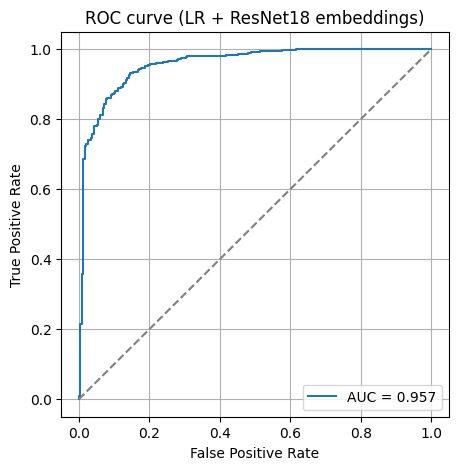

In [ ]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Collect to pandas (small)
pdf_pred = pred.select("label", "p1").toPandas()

fpr, tpr, _ = roc_curve(pdf_pred["label"], pdf_pred["p1"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (LR + ResNet18 embeddings)")
plt.legend()
plt.grid(True)
plt.show()


###**Precission-Recall curve**

The Precission-Recall curve is especially important for medical imaging tasks like pneumonia detection because it focuses on the positive class and is more informative than ROC curves when classes are imbalanced, helping assess how many flagged cases are truly positive as the model becomes more sensitive.

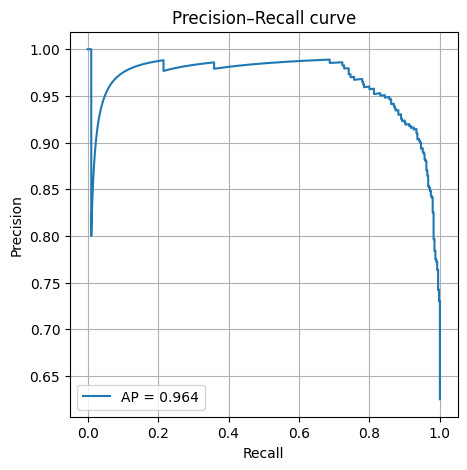

In [ ]:
# Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(pdf_pred["label"], pdf_pred["p1"])
ap = average_precision_score(pdf_pred["label"], pdf_pred["p1"])

plt.figure(figsize=(5,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.grid(True)
plt.show()


###**Effect of decision threshold plot**

Higher thresholds typically increase precision but reduce recall, and vice versa. This is important because it allows to choose a threshold (such as 0.7 here) that aligns with clinical priorities—often favoring high recall to avoid missing pneumonia cases while keeping false positives at an acceptable level.

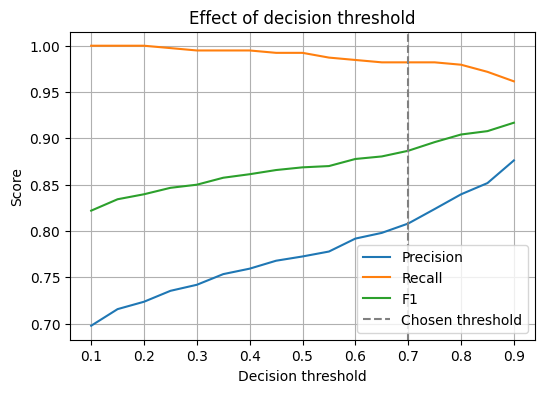

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 17)

precisions, recalls, f1s = [], [], []

y_true = pdf_pred["label"].values
y_score = pdf_pred["p1"].values

for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred))

plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1")
plt.axvline(0.7, linestyle="--", color="gray", label="Chosen threshold")
plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.title("Effect of decision threshold")
plt.legend()
plt.grid(True)
plt.show()
